# CSCA 5642 Final: Image Colorization using GAN

I will be tackling image colorization using GAN (Generative Adversarial Network).
The dataset will be sourced from Kaggle's [Landscape color and grayscale images](https://www.kaggle.com/datasets/theblackmamba31/landscape-image-colorization)

### Background

Generative Adversarial Network architecture consists of two primary components: a generator and a discriminator.  The generator attempts to create data that resembles a real data to "fool" the discriminator.  Discriminator on the other hand tries to distinguish between the real data and the data generator fabricated.  Generator's tasks is to produce results that are inditinguishable from real data.

### Understanding different types of computer vision problems
There are number of common computer vision and image manipulation problems.
- Image-to-Image Translation
  - Style Transfer: Converting photos to resemble paintings of specific artists
  - Domain Translation: Converting horses to zebras, summer to winter scenes
  - Colorization: Adding realistic color to grayscale images
  - Super-Resolution: Generating high-resolution details from low-resolution images
  - Image Inpainting: Filling in missing or damaged parts of images
  - Sketch-to-Photo Conversion: Generating realistic images from simple sketches
  - Image colorization provide a unique challenge that differ from other types of image manipulations.
- Image Synthesis
  - Photorealistic Image Generation: Creating completely new but realistic-looking images
  - Conditional Image Generation: Creating images based on textual descriptions or class labels
  - Face Generation: Creating realistic human faces that don't exist
  - Texture Synthesis: Creating new textures with consistent patterns
- Image Editing and Manipulation
  - Face Aging/De-aging: Modifying images to show how someone might look older or younger
  - Image Harmonization: Integrating edited content seamlessly into images
  - Semantic Image Manipulation: Modifying images based on high-level descriptions
  - Weather/Time of Day Manipulation: Changing the weather or lighting conditions in photos

We must choose an architecture that is a good fit for Image Colorization

### Choosing the Ideal Machine Learning Model for Image Colorization

While there exists several options to train a deep learning model, after research, I have chosen pix2pix as the GAN architecture.

### Other Options:

**Standard Autoencoders**

Just using autoencoders, instead of GAN, is the simplest approach to encode the grayscale images into compressed latent representation, then decoding this representation back into colorized image.  While this is straight forward, we would lose many details during the compression stage.

**Deep Convolutional GAN (DCGAN)**

I used DCGan for week 5 monet style image creation.  While DCGan is a good candidate to perform pure generation, we don't need to create any image from scratch,  we only need to keep the existing style, only change the color.

**CycleGAN**

CycleGan built for "unpaired" image-to-image translation.  This is a good fit style transfer. (Such as applying Monet style transfer on existing images.)  There is a one key difference, since this is "unpaired" there doesn't need to be a corresponding target output image for every input image in the dataset.  (such was the case for Modet style transfer problem)

### Choosing Pix2Pix

What makes pix2pix particularly suited for image colorization is its ability to balance determinism (preserving the input structure) with creativity (applying colors). Also, we have target output image (colored image) for every input image (grayscale). Pix2Pix requires "paired" dataset, so the problem fits the Pix2Pix model the best.

# Exploratory Data Analysis

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from PIL import Image
import pandas as pd


import tensorflow as tf
import time

In [2]:
IMAGE_PATH = './archive/landscape Images'

COLOR_PATH = IMAGE_PATH + '/color'
GRAY_PATH = IMAGE_PATH + '/gray'

In [3]:
print("Number of Color images: ",len(os.listdir(COLOR_PATH)))
print("Number of Gray images: ",len(os.listdir(GRAY_PATH)))

print("Color filenames: ",os.listdir(COLOR_PATH)[:20])
print("Gray filenames: ",os.listdir(GRAY_PATH)[:20])

NUMBER_OF_IMAGES = len(os.listdir(COLOR_PATH))

Number of Color images:  7129
Number of Gray images:  7129
Color filenames:  ['0.jpg', '1.jpg', '10.jpg', '100.jpg', '1000.jpg', '1001.jpg', '1002.jpg', '1003.jpg', '1004.jpg', '1005.jpg', '1006.jpg', '1007.jpg', '1008.jpg', '1009.jpg', '101.jpg', '1010.jpg', '1011.jpg', '1012.jpg', '1013.jpg', '1014.jpg']
Gray filenames:  ['0.jpg', '1.jpg', '10.jpg', '100.jpg', '1000.jpg', '1001.jpg', '1002.jpg', '1003.jpg', '1004.jpg', '1005.jpg', '1006.jpg', '1007.jpg', '1008.jpg', '1009.jpg', '101.jpg', '1010.jpg', '1011.jpg', '1012.jpg', '1013.jpg', '1014.jpg']


There are 7129 color and grayscale images.  Named from 0.jpg to 7128.jpg in each directory.

In [4]:
def create_dataframe(path):
    data = pd.DataFrame({'fileName': os.listdir(path)})
    data['filePath'] = data['fileName'].apply(lambda x: os.path.join(path, x))
    data['fileSize'] = data['filePath'].apply(lambda x: os.path.getsize(x))
    
    # to get around too many open files error
    # for (i, row) in data.iterrows():
    #     image = cv2.imread(row['filePath'])
    #     data.at[i, 'height'] = image.shape[0]
    #     data.at[i, 'width'] = image.shape[1]
    #     data.at[i, 'aspectRatio'] = round(image.shape[1] / image.shape[0], 2)
    #     data.at[i, 'channels'] = image.shape[2]
    data['img'] = data['filePath'].apply(lambda x: cv2.imread(x))
    data['height'] = data['img'].apply(lambda x: x.shape[0])
    data['width'] = data['img'].apply(lambda x: x.shape[1])
    data['aspectRatio'] = round(data['width'] / data['height'],2)
    data['channels'] = data['img'].apply(lambda x: x.shape[2])
    data['color'] = data['img'].apply(lambda x: cv2.cvtColor(x, cv2.COLOR_BGR2RGB))
    data['gray'] = data['img'].apply(lambda x: cv2.cvtColor(x, cv2.COLOR_BGR2GRAY))
    
    
        
    return data
    
color_df = create_dataframe(COLOR_PATH)
gray_df = create_dataframe(GRAY_PATH)

In [5]:
print("Color Image Info")
print(color_df.info())
print(color_df.describe())

Color Image Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7129 entries, 0 to 7128
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   fileName     7129 non-null   object 
 1   filePath     7129 non-null   object 
 2   fileSize     7129 non-null   int64  
 3   img          7129 non-null   object 
 4   height       7129 non-null   int64  
 5   width        7129 non-null   int64  
 6   aspectRatio  7129 non-null   float64
 7   channels     7129 non-null   int64  
 8   color        7129 non-null   object 
 9   gray         7129 non-null   object 
dtypes: float64(1), int64(4), object(5)
memory usage: 557.1+ KB
None
           fileSize       height   width  aspectRatio  channels
count   7129.000000  7129.000000  7129.0  7129.000000    7129.0
mean   15439.242951   149.886800   150.0     1.001202       3.0
std     3983.794325     2.414406     0.0     0.028314       0.0
min     4874.000000    72.000000   150.0     1.

In [6]:
print("Gray Image Info")
print(gray_df.info())
print(gray_df.describe())

Gray Image Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7129 entries, 0 to 7128
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   fileName     7129 non-null   object 
 1   filePath     7129 non-null   object 
 2   fileSize     7129 non-null   int64  
 3   img          7129 non-null   object 
 4   height       7129 non-null   int64  
 5   width        7129 non-null   int64  
 6   aspectRatio  7129 non-null   float64
 7   channels     7129 non-null   int64  
 8   color        7129 non-null   object 
 9   gray         7129 non-null   object 
dtypes: float64(1), int64(4), object(5)
memory usage: 557.1+ KB
None
           fileSize       height   width  aspectRatio  channels
count   7129.000000  7129.000000  7129.0  7129.000000    7129.0
mean   13101.775144   149.886800   150.0     1.001202       3.0
std     3360.424840     2.414406     0.0     0.028314       0.0
min     3585.000000    72.000000   150.0     1.0

Most images are 150x150.  There seems to be an outlier.  we'll remove this to get around any unwanted outlier

In [7]:
print("non 150 height images")
print(color_df[color_df['height'] != 150].shape)
print(gray_df[gray_df['height'] != 150].shape)

non 150 height images
(23, 10)
(23, 10)


Only 23 images are not 150x150.  Let's make sure they are the same images, and remove them from the dataset

In [8]:
color_bad = color_df[color_df['height'] != 150].fileName
gray_bad = gray_df[gray_df['height'] != 150].fileName

print("Making sure the bad images are the same")
print(color_bad.equals(gray_bad))
print("Removing bad images")
color_df_cleaned = color_df[color_df['height'] == 150]
gray_df_cleaned = gray_df[gray_df['height'] == 150]

Making sure the bad images are the same
True
Removing bad images


## Sample Images

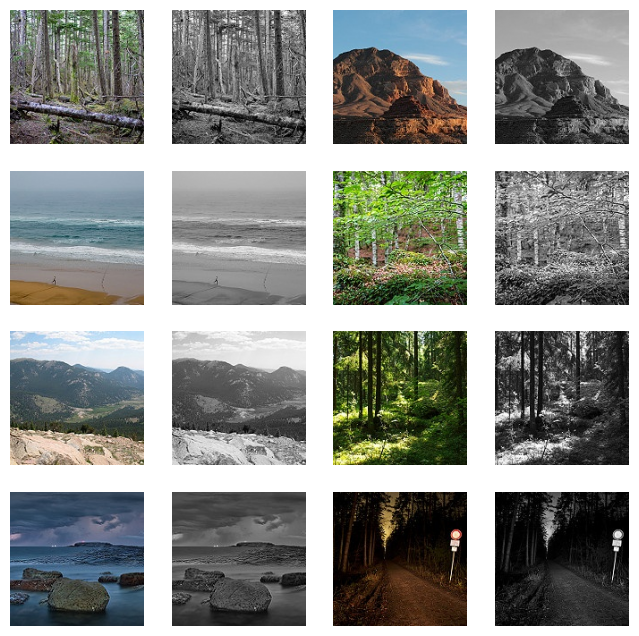

In [9]:
def display_sample_images(n=4, cols=4):
    
    sample_size = n * cols
    
    file_nums = np.random.randint(0, NUMBER_OF_IMAGES, sample_size // 2)
    
    plt.figure(figsize=(8, 8))
    for i, file_num in enumerate(file_nums):
        # Show Color Image
        img = Image.open(os.path.join(COLOR_PATH, str(file_num) + ".jpg"))
        plt.subplot(n, cols, i*2+1)
        plt.imshow(img)
        plt.axis('off')
        
        # Show Gray Image
        img2 = Image.open(os.path.join(GRAY_PATH, str(file_num) + ".jpg"))
        plt.subplot(n, cols, i*2+2)
        # color map gray.  Otherwise it will be shown in RGB
        plt.imshow(img2, cmap="gray")
        plt.axis('off')
    plt.show()
    
display_sample_images()


In [10]:
def analyze_color_distribution(images, n_samples=10):
    """
    Analyze the color distribution in the dataset
    """
    # Sample a subset of images for this analysis
    if len(images) > n_samples:
        sample_indices = np.random.choice(len(images), n_samples, replace=False)
        sample_images = [images[i] for i in sample_indices]
    else:
        sample_images = images
    
    # Analyze RGB distribution
    r_values = []
    g_values = []
    b_values = []
    
    for img in sample_images:
        # Flatten the image and collect color values
        pixels = img.reshape(-1, 3)
        r_values.extend(pixels[:, 0])
        g_values.extend(pixels[:, 1])
        b_values.extend(pixels[:, 2])
    
    # Plot histograms
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.hist(r_values, bins=50, color='red', alpha=0.7)
    plt.title('Red Channel Distribution')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 3, 2)
    plt.hist(g_values, bins=50, color='green', alpha=0.7)
    plt.title('Green Channel Distribution')
    plt.xlabel('Pixel Value')
    
    plt.subplot(1, 3, 3)
    plt.hist(b_values, bins=50, color='blue', alpha=0.7)
    plt.title('Blue Channel Distribution')
    plt.xlabel('Pixel Value')
    
    plt.tight_layout()
    plt.show()
    
    # return r_values, g_values, b_values



## Color Images color distributions

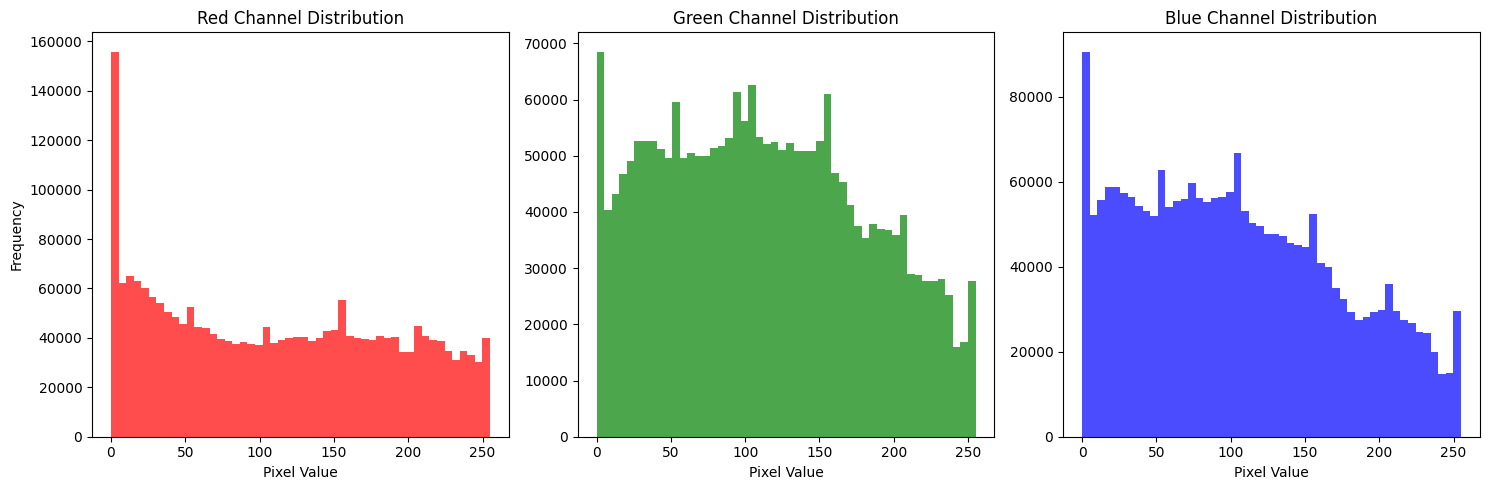

In [11]:
analyze_color_distribution(color_df_cleaned['img'].values, n_samples=100)

## Gray Images Color Distributions

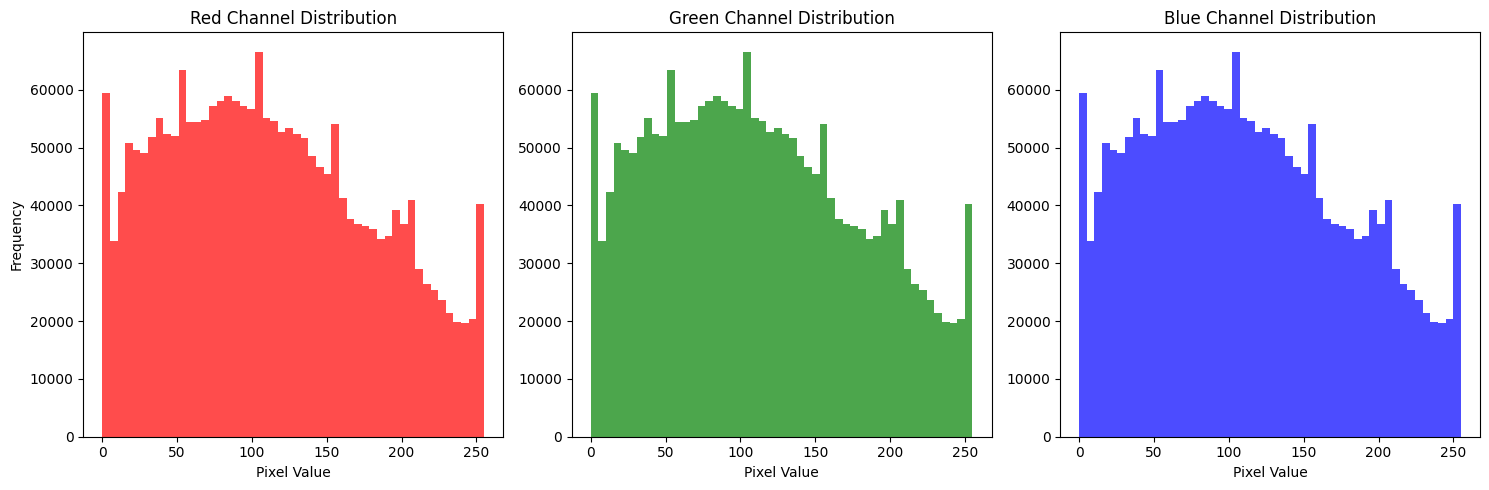

In [12]:
analyze_color_distribution(gray_df_cleaned['img'].values, n_samples=100)

In [13]:
# Function to analyze color vs grayscale pixel correlation
def analyze_color_grayscale_correlation(color_images, gray_images, n_samples=5):
    """
    Analyze how well grayscale values correlate with original color values
    """
    if len(color_images) > n_samples:
        sample_indices = np.random.choice(len(color_images), n_samples, replace=False)
    else:
        sample_indices = range(len(color_images))
    
    correlations = []
    
    for idx in sample_indices:
        color_img = color_images[idx]
        gray_img = gray_images[idx]
        
        # Convert color image to grayscale for comparison
        color_gray = cv2.cvtColor(color_img, cv2.COLOR_RGB2GRAY)
        
        # Extract first channel from grayscale image (all channels should be the same)
        if len(gray_img.shape) == 3:
            gray_channel = gray_img[:,:,0]
        else:
            gray_channel = gray_img
        
        # Calculate correlation
        correlation = np.corrcoef(color_gray.flatten(), gray_channel.flatten())[0,1]
        correlations.append(correlation)
        
        # Display example
        plt.figure(figsize=(6, 3))
        
        plt.subplot(1, 3, 1)
        plt.imshow(color_img)
        plt.title('Original Color')
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(color_gray, cmap='gray')
        plt.title('Grayscale from Color')
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.imshow(gray_channel, cmap='gray')
        plt.title('Dataset Grayscale')
        plt.axis('off')
        
        plt.suptitle(f'Correlation: {correlation:.4f}')
        plt.tight_layout()
        plt.show()
    
    return correlations

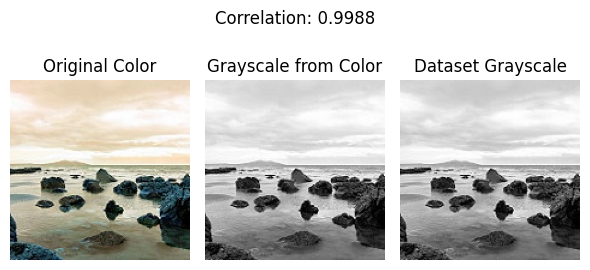

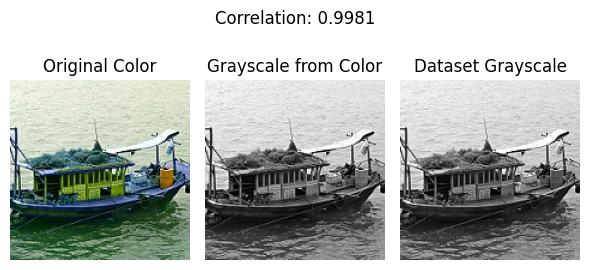

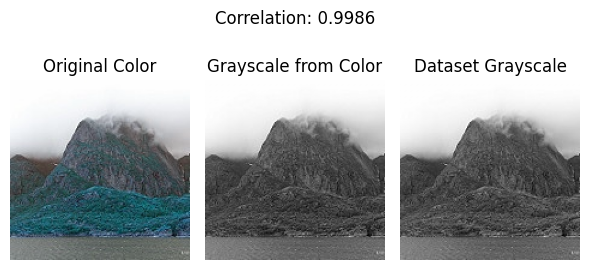

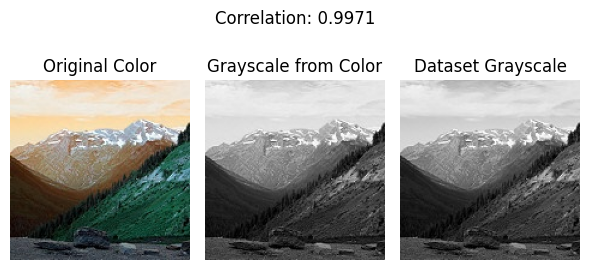

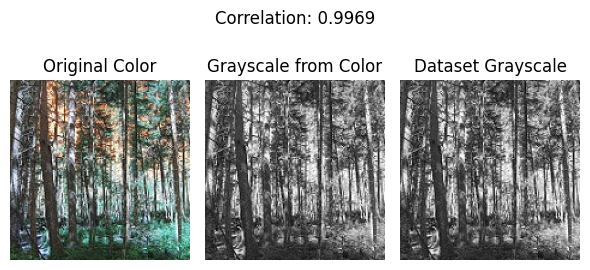

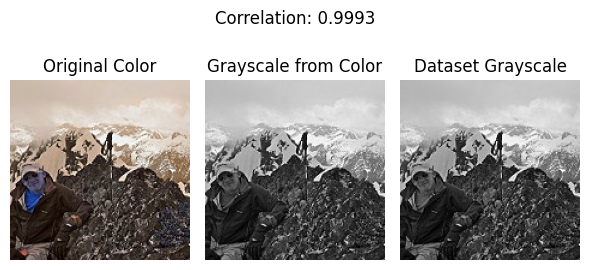

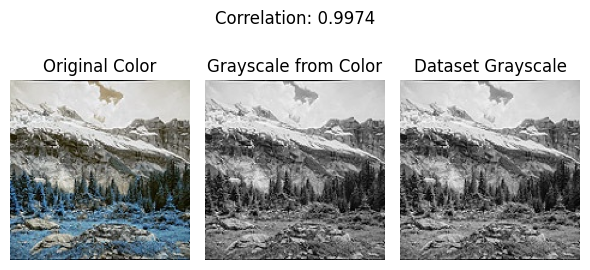

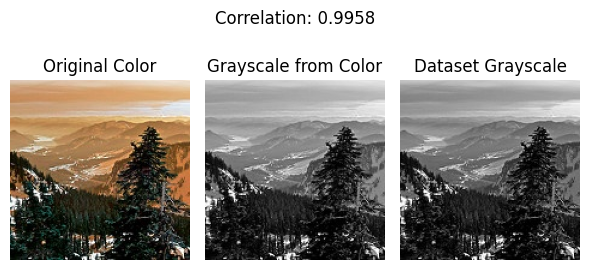

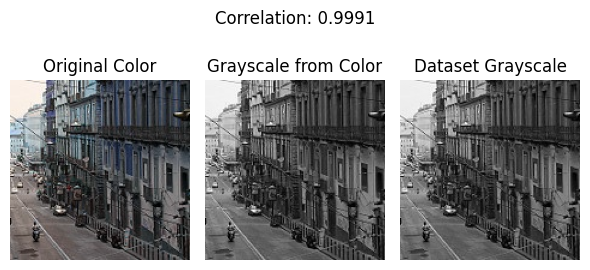

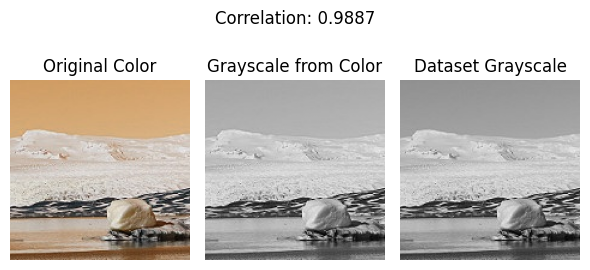

[0.9988253298493663,
 0.9981369298918897,
 0.9986021087781904,
 0.9971128897704719,
 0.996919788269866,
 0.9993049660623511,
 0.9974031655513361,
 0.9957646458588205,
 0.9990867135643853,
 0.988689318223391]

In [14]:
analyze_color_grayscale_correlation(color_df_cleaned['img'].values, gray_df_cleaned['img'].values, n_samples=10)

As expected, the color images turned to grayscale is pretty much the same as the gray images.

In [15]:
IMAGE_SIZE = 128

### Tanh Activation and Normalization

Tanh is used for several reasons:

Bounded Output: Tanh maps values to the range [-1, 1], which is ideal for image generation when using normalization

#### Image Normalization and Denormalization
The code normalizes the input images to the range [-1, 1] to match the tanh output range:
```python
color_image = (color_image.astype(np.float32) / 127.5) - 1.0
gray_image = (gray_image.astype(np.float32) / 127.5) - 1.0
```

When displaying the generated images, they are denormalized back to [0, 1] for proper visualization:
plt.imshow(display_list[i] * 0.5 + 0.5)  # Rescale to [0, 1]

In [16]:
def prepare_data_from_dataframe(color_df, gray_df):
    """
    Prepare data from pandas DataFrames containing image data

    Args:
        color_df: DataFrame with color images
        gray_df: DataFrame with grayscale images

    Returns:
        Arrays of color and grayscale images, plus list of filenames
    """
    # Make sure the DataFrames are matched by filename
    color_df = color_df.set_index('fileName')
    gray_df = gray_df.set_index('fileName')
    common_files = set(color_df.index).intersection(set(gray_df.index))

    print(f"Found {len(common_files)} matching image pairs")

    # Create empty lists to store preprocessed images
    color_img = []
    gray_img = []
    filenames = []  # Track filenames

    # Process each image pair
    print("Processing images...")
    for filename in common_files:
        # Get color image and normalize
        color_image = color_df.loc[filename, 'color']

        # Get grayscale image and normalize
        gray_image = gray_df.loc[filename, 'color']

        color_image = cv2.resize(color_image, (IMAGE_SIZE, IMAGE_SIZE))
        gray_image = cv2.resize(gray_image, (IMAGE_SIZE, IMAGE_SIZE))

        color_image = (color_image.astype(np.float32) / 127.5) - 1.0 # Normalize to [-1, 1] since we are using tanh activation function
        gray_image = (gray_image.astype(np.float32) / 127.5) - 1.0  # Normalize to [-1, 1] since we are using tanh activation function

        color_img.append(color_image)
        gray_img.append(gray_image)
        filenames.append(filename)  # Store the filename

    return np.array(color_img), np.array(gray_img), filenames

color_images, gray_images, filenames = prepare_data_from_dataframe(color_df_cleaned, gray_df_cleaned)

Found 7106 matching image pairs
Processing images...


In [17]:
BATCH_SIZE = 4
LAMBDA = 100
EPOCHS = 30

In [18]:
def preprocess_data(color_images, gray_images, filenames, train_split=0.8):
    """Split data into training and validation sets"""
    # Determine split index
    num_samples = len(color_images)
    split_idx = int(num_samples * train_split)

    # Create training datasets
    train_color = color_images[:split_idx]
    train_gray = gray_images[:split_idx]
    train_filenames = filenames[:split_idx]

    # Create validation datasets
    val_color = color_images[split_idx:]
    val_gray = gray_images[split_idx:]
    val_filenames = filenames[split_idx:]

    # Create TensorFlow datasets for images
    train_dataset = tf.data.Dataset.from_tensor_slices((train_gray, train_color))
    train_dataset = train_dataset.batch(BATCH_SIZE)
    train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    val_dataset = tf.data.Dataset.from_tensor_slices((val_gray, val_color))
    val_dataset = val_dataset.batch(BATCH_SIZE)
    val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    # Create TensorFlow datasets for filenames
    train_filenames_dataset = tf.data.Dataset.from_tensor_slices(train_filenames)
    train_filenames_dataset = train_filenames_dataset.batch(BATCH_SIZE)

    val_filenames_dataset = tf.data.Dataset.from_tensor_slices(val_filenames)
    val_filenames_dataset = val_filenames_dataset.batch(BATCH_SIZE)

    return train_dataset, val_dataset, train_filenames_dataset, val_filenames_dataset

train_dataset, val_dataset, train_filenames_dataset, val_filenames_dataset = preprocess_data(
        color_images, gray_images, filenames)

## Building the Pix2Pix Generator

The pix2pix framework is a conditional GAN designed specifically for paired image-to-image translation tasks. It consists of two main components:

#### Generator (U-Net): Transforms grayscale images to color

#### Discriminator (PatchGAN): Determines if image pairs are real or fake

In [19]:
# Model building functions
def downsample(filters, size, apply_batchnorm=True):
    """Downsampling block for the generator"""
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                              kernel_initializer=initializer, use_bias=False))
    
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
    
    result.add(tf.keras.layers.LeakyReLU())
    
    return result

def upsample(filters, size, apply_dropout=False):
    """Upsampling block for the generator"""
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                       kernel_initializer=initializer, use_bias=False))
    
    result.add(tf.keras.layers.BatchNormalization())
    
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    
    result.add(tf.keras.layers.ReLU())
    
    return result

### Building the U-Net Generator

The U-Net architecture consists of three main parts:

**1. Encoder** 

A series of convolutional and pooling layers that progressively reduce spatial dimensions while increasing feature depth:

Each downsample block consists of:

Conv2D layer (with stride 2 for downsampling)
BatchNormalization
LeakyReLU activation

```python
down_stack = [
    downsample(16, 4, apply_batchnorm=False),  # (batch_size, 64, 64, 16)
    downsample(32, 4),                         # (batch_size, 32, 32, 32)
    downsample(64, 4),                         # (batch_size, 16, 16, 64)
    downsample(128, 4),                        # (batch_size, 8, 8, 128)
    downsample(256, 4),                        # (batch_size, 4, 4, 256)
    downsample(256, 4),                        # (batch_size, 2, 2, 256)
]
```

**2. Decoder**

A series of upsampling and convolutional layers that progressively increase spatial dimensions while decreasing feature depth:

```python
up_stack = [
        upsample(256, 4, apply_dropout=True),      # (batch_size, 4, 4, 256)
        upsample(128, 4, apply_dropout=True),      # (batch_size, 8, 8, 128)
        upsample(64, 4),                           # (batch_size, 16, 16, 64)
        upsample(32, 4),                           # (batch_size, 32, 32, 32)
        upsample(16, 4),                           # (batch_size, 64, 64, 16)
    ]
```

**3. Skip Connections**

Direct connections between corresponding layers in the Encoders and Decoders.

During the encoding phase, the output of each downsampling block is stored
During the decoding phase, these stored outputs are concatenated with the corresponding upsampling block's output

What Skip Connections Achieve:

Preservation of Fine Details: Low-level information (edges, textures) from early layers is directly passed to the decoder, helping preserve spatial details that might otherwise be lost in the bottleneck
Gradient Flow: They provide additional paths for gradients to flow during backpropagation, helping mitigate the vanishing gradient problem
Feature Reuse: The decoder can reuse features extracted by the encoder at various scales

**For colorization specifically, skip connections are vital because they help carry over the outline, lighting and texture from grayscale image to the colored images**

![image](./long-skip-connection.jpg)

In [20]:
def build_generator():
    """Build the U-Net generator model - true to pix2pix but with memory efficiency"""
    inputs = tf.keras.layers.Input(shape=[IMAGE_SIZE, IMAGE_SIZE, 3])
    
    # Encoder (downsampling)
    # Using fewer filters at each layer compared to original pix2pix
    down_stack = [
        downsample(16, 4, apply_batchnorm=False),  # (batch_size, 64, 64, 16)
        downsample(32, 4),                         # (batch_size, 32, 32, 32)
        downsample(64, 4),                         # (batch_size, 16, 16, 64)
        downsample(128, 4),                        # (batch_size, 8, 8, 128)
        downsample(256, 4),                        # (batch_size, 4, 4, 256)
        downsample(256, 4),                        # (batch_size, 2, 2, 256)
    ]
    
    # Encoder pass
    x = inputs
    skips = []
    
    for down in down_stack:
        x = down(x)
        skips.append(x)
    
    skips = reversed(skips[:-1])
    
    # Decoder (upsampling)
    # Using fewer filters at each layer compared to original pix2pix
    up_stack = [
        upsample(256, 4, apply_dropout=True),      # (batch_size, 4, 4, 256)
        upsample(128, 4, apply_dropout=True),      # (batch_size, 8, 8, 128)
        upsample(64, 4),                           # (batch_size, 16, 16, 64)
        upsample(32, 4),                           # (batch_size, 32, 32, 32)
        upsample(16, 4),                           # (batch_size, 64, 64, 16)
    ]
    
    # Decoder pass with skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        # Handle dimension issues with resize if needed
        if x.shape[1] != skip.shape[1] or x.shape[2] != skip.shape[2]:
            x = tf.image.resize(x, [skip.shape[1], skip.shape[2]])
        x = tf.keras.layers.Concatenate()([x, skip])
    
    # Final output layer
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(
        3, 4, strides=2, padding='same',
        kernel_initializer=initializer, activation='tanh')  # (batch_size, 128, 128, 3)
    
    x = last(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)

### Building the PatchGAN Discriminator

PatchGAN Advantages for Colorization
PatchGAN offers several advantages for image colorization:

- Focus on Local Textures: By classifying patches rather than entire images, PatchGAN focuses on local textures and patterns, which is particularly useful for colorization where local color consistency is important.
- Computational Efficiency: PatchGAN uses fewer parameters than a full-image discriminator, making it more computationally efficient.
- Detail Preservation: By focusing on patches, the discriminator encourages the generator to produce realistic details at multiple scales and locations

In [21]:
def build_discriminator():
    """Build the PatchGAN discriminator - true to pix2pix but with memory efficiency"""
    initializer = tf.random_normal_initializer(0., 0.02)
    
    # Input layers
    inp = tf.keras.layers.Input(shape=[IMAGE_SIZE, IMAGE_SIZE, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[IMAGE_SIZE, IMAGE_SIZE, 3], name='target_image')
    
    # Concatenate inputs
    x = tf.keras.layers.Concatenate()([inp, tar])  # (batch_size, 128, 128, 6)
    
    # PatchGAN layers - using fewer filters than original
    down1 = downsample(16, 4, False)(x)            # (batch_size, 64, 64, 16)
    down2 = downsample(32, 4)(down1)               # (batch_size, 32, 32, 32)
    down3 = downsample(64, 4)(down2)               # (batch_size, 16, 16, 64)
    
    # Zero padding and final convolution
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)
    conv = tf.keras.layers.Conv2D(
        256, 4, strides=1, padding='valid',
        kernel_initializer=initializer, use_bias=False)(zero_pad1)
    
    batchnorm = tf.keras.layers.BatchNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm)
    
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)
    # Final 1x1 output (without sigmoid - will use from_logits=True in loss)
    last = tf.keras.layers.Conv2D(
        1, 4, strides=1, padding='valid',
        kernel_initializer=initializer)(zero_pad2)
    
    return tf.keras.Model(inputs=[inp, tar], outputs=last)

### Loss Functions

There are two main loss functions.

**Adversarial Loss**

This measures how well generator is "fooling" the discriminator

**L1 Loss**

Measures the absolute difference between the generated colors and the ground truth. This encourages color accuracy.

The combined loss function is: Total Loss = Adversarial Loss + λ × L1 Loss

Where λ (LAMBDA) is a weighting factor to prioritize color accuracy.

We have set this value to 100

In [22]:
def generator_loss(disc_generated_output, gen_output, target):
    """Calculate generator loss"""
    # GAN loss for fooling the discriminator
    gan_loss = tf.keras.losses.BinaryCrossentropy(
        from_logits=True)(tf.ones_like(disc_generated_output), disc_generated_output)
    
    # L1 loss for color accuracy
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    
    # Combined loss
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    
    return total_gen_loss, gan_loss, l1_loss

def discriminator_loss(disc_real_output, disc_generated_output):
    """Calculate discriminator loss"""
    # Real image loss
    real_loss = tf.keras.losses.BinaryCrossentropy(
        from_logits=True)(tf.ones_like(disc_real_output), disc_real_output)
    
    # Generated image loss
    generated_loss = tf.keras.losses.BinaryCrossentropy(
        from_logits=True)(tf.zeros_like(disc_generated_output), disc_generated_output)
    
    # Total loss
    total_disc_loss = real_loss + generated_loss
    
    return total_disc_loss

In [23]:
@tf.function
def train_step(input_images, target_images, generator, discriminator, 
               generator_optimizer, discriminator_optimizer):
    """Single training step"""
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate colorized output
        gen_output = generator(input_images, training=True)
        
        # Discriminator predictions
        disc_real_output = discriminator([input_images, target_images], training=True)
        disc_generated_output = discriminator([input_images, gen_output], training=True)
        
        # Calculate losses
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(
            disc_generated_output, gen_output, target_images)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
    
    # Calculate gradients
    generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    # Apply gradients
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))
    
    return gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss

In [24]:
def display_sample_results(model, dataset, filenames_dataset, num_samples=4):
    """Display sample results during training
    
    Args:
        model: The generator model
        dataset: Dataset containing input and target images
        filenames_dataset: Optional dataset containing filenames corresponding to the images
        num_samples: Number of samples to display
    """

    filenames_batch = next(iter(filenames_dataset.take(1)))
        
    # Get the image batch
    for input_image, target_image in dataset.take(1):

        samples_to_display = min(num_samples, input_image.shape[0])
        
        for i in range(samples_to_display):

            filename = filenames_batch[i].numpy().decode('utf-8')

            generate_and_save_images(
                model,
                input_image[i:i+1],
                target_image[i:i+1],
                sample_name=filename
            )


def generate_and_save_images(model, test_input, target, filename=None, sample_name=None):
    """Generate colorized images and save if filename is provided
    
    Args:
        model: The generator model
        test_input: Input grayscale image
        target: Target color image
        filename: Optional filename to save the figure
        sample_name: Original filename or identifier to display in the title
    """
    prediction = model(test_input, training=False)

    # Adjusted figure size to better fit 128x128 images
    plt.figure(figsize=(7, 2))
    
    # Add the sample name to the figure title if provided
    title_text = f"Image Colorization: {sample_name}" if sample_name else "Image Colorization Results"
    plt.suptitle(title_text, fontsize=10)

    display_list = [test_input[0], target[0], prediction[0]]
    title = ['Input (Grayscale)', 'Ground Truth (Color)', 'Predicted (Color)']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i], fontsize=10)

        # Rescale to [0, 1] for display
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Make room for suptitle

    if filename:
        plt.savefig(filename)
        plt.close()
    else:
        plt.show()


## Environment Set up
I set up the environment to use the GPU on my desktop since deep learning network is compute intensive computations that matches what GPU excels at.

#### Machine
- Nvidia GeForce RTX 2060 6GB (Released 2020)

#### Software Environment
- Python 3.10.1
- Tensorflow 2.10
- CUDA 11.8
- cuDNN 8.1.1

For more detail.  See requirements.txt.

CUDA (Compute Unified Device Architecture) is a parallel computing platform and programming model developed by NVIDIA. It allows developers to use NVIDIA GPUs for general-purpose processing (GPGPU)

cuDNN (CUDA Deep Neural Network library) is a GPU-accelerated library specifically designed for deep learning operations. It's built on top of CUDA and provides highly optimized implementations for common deep learning operations such as:

- Convolutions
- Pooling
- Normalization
- Activation functions
- Tensor transformations


## Training the Model and Hyperparameter Tuning

One key aspect of training a GAN model is balacing the learning between the generator and the discriminator model.

We can achieve this easily by tuning the learning rate.

After trying out bunch of differen options.  The best combinations that I achieved was with

```python
    generator_optimizer = tf.keras.optimizers.Adam(8e-5, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(4e-5, beta_1=0.3)
```

In [25]:
def train_model(train_dataset, val_dataset, train_filenames_dataset, val_filenames_dataset, epochs):
    """Train the pix2pix model"""
    print("Starting training...")
    # Build models
    generator = build_generator()
    print(generator.summary())
    discriminator = build_discriminator()
    print(discriminator.summary())

    # Define optimizers
    generator_optimizer = tf.keras.optimizers.Adam(8e-5, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(4e-5, beta_1=0.3)
    
    # Initialize arrays to store loss values
    train_gen_losses = []
    train_disc_losses = []
    train_l1_losses = []
    val_gen_losses = []
    val_disc_losses = []
    val_l1_losses = []

    # Create checkpoints
    checkpoint_dir = './checkpoints'
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(
        generator_optimizer=generator_optimizer,
        discriminator_optimizer=discriminator_optimizer,
        generator=generator,
        discriminator=discriminator)

    # Ensure checkpoint directory exists
    os.makedirs(checkpoint_dir, exist_ok=True)

    # Training loop
    for epoch in range(epochs):
        start_time = time.time()

        # Initialize metrics
        gen_total_loss_avg = tf.keras.metrics.Mean()
        gen_gan_loss_avg = tf.keras.metrics.Mean()
        gen_l1_loss_avg = tf.keras.metrics.Mean()
        disc_loss_avg = tf.keras.metrics.Mean()

        print(f"Epoch {epoch+1}/{epochs}")
        

        # Training
        for input_image, target_image in train_dataset:
            # Train on batch
            gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss = train_step(
                input_image, target_image, generator, discriminator,
                generator_optimizer, discriminator_optimizer)

            # Update metrics
            gen_total_loss_avg.update_state(gen_total_loss)
            gen_gan_loss_avg.update_state(gen_gan_loss)
            gen_l1_loss_avg.update_state(gen_l1_loss)
            disc_loss_avg.update_state(disc_loss)
            
        
        train_gen_losses.append(gen_total_loss_avg.result().numpy())
        train_disc_losses.append(disc_loss_avg.result().numpy())
        train_l1_losses.append(gen_l1_loss_avg.result().numpy())

        # Validation
        val_gen_total_loss_avg = tf.keras.metrics.Mean()
        val_gen_gan_loss_avg = tf.keras.metrics.Mean()
        val_gen_l1_loss_avg = tf.keras.metrics.Mean()
        val_disc_loss_avg = tf.keras.metrics.Mean()

        for input_image, target_image in val_dataset:
            # Generate output
            gen_output = generator(input_image, training=False)

            # Discriminator predictions
            disc_real_output = discriminator(
                [input_image, target_image], training=False)
            disc_generated_output = discriminator(
                [input_image, gen_output], training=False)

            # Calculate losses
            gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(
                disc_generated_output, gen_output, target_image)
            disc_loss = discriminator_loss(
                disc_real_output, disc_generated_output)

            # Update metrics
            val_gen_total_loss_avg.update_state(gen_total_loss)
            val_gen_gan_loss_avg.update_state(gen_gan_loss)
            val_gen_l1_loss_avg.update_state(gen_l1_loss)
            val_disc_loss_avg.update_state(disc_loss)
            
        val_gen_losses.append(val_gen_total_loss_avg.result().numpy())
        val_disc_losses.append(val_disc_loss_avg.result().numpy())
        val_l1_losses.append(val_gen_l1_loss_avg.result().numpy())

        # Print epoch results
        time_taken = time.time() - start_time
        print(f"Time taken: {time_taken:.2f}s")

        print(f"Training: Gen Loss: {gen_total_loss_avg.result():.4f}, "
              f"Gen GAN Loss: {gen_gan_loss_avg.result():.4f}, "
              f"Gen L1 Loss: {gen_l1_loss_avg.result():.4f}, "
              f"Disc Loss: {disc_loss_avg.result():.4f}")

        print(f"Validation: Gen Loss: {val_gen_total_loss_avg.result():.4f}, "
              f"Gen GAN Loss: {val_gen_gan_loss_avg.result():.4f}, "
              f"Gen L1 Loss: {val_gen_l1_loss_avg.result():.4f}, "
              f"Disc Loss: {val_disc_loss_avg.result():.4f}")

        # Save checkpoint every 5 epochs
        if (epoch + 1) % 5 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        # Generate and display sample images
        if (epoch + 1) % 4 == 0:
            # Now pass the filenames dataset to the display function
            display_sample_results(generator, val_dataset, val_filenames_dataset, num_samples=4)

    # Final save
    checkpoint.save(file_prefix=checkpoint_prefix)

    return generator, discriminator, {
        'train_gen_losses': train_gen_losses,
        'train_disc_losses': train_disc_losses,
        'train_l1_losses': train_l1_losses,
        'val_gen_losses': val_gen_losses,
        'val_disc_losses': val_disc_losses,
        'val_l1_losses': val_l1_losses
    }

Starting training...
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 64, 64, 16)   768         ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 32, 32, 32)   8320        ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 16, 16, 64)   33024       ['sequen

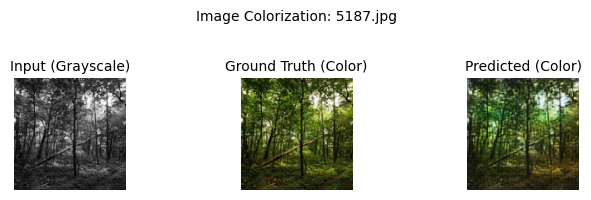

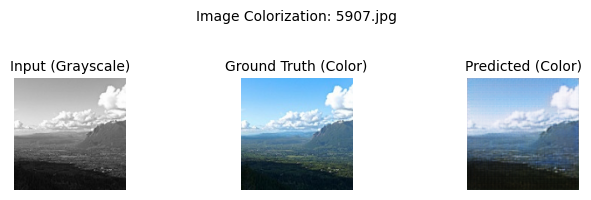

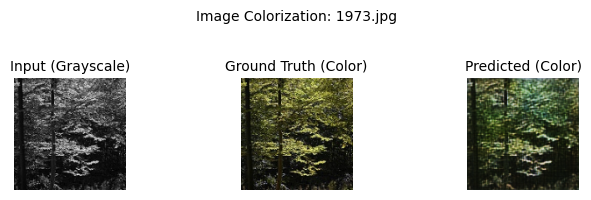

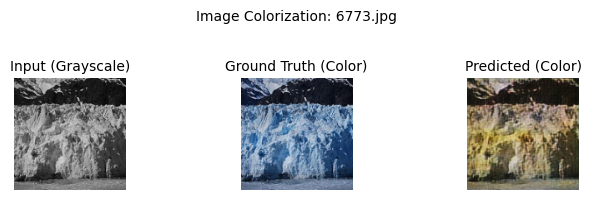

Epoch 5/25
Time taken: 37.77s
Training: Gen Loss: 12.7514, Gen GAN Loss: 1.1287, Gen L1 Loss: 0.1162, Disc Loss: 1.0488
Validation: Gen Loss: 13.8554, Gen GAN Loss: 0.6903, Gen L1 Loss: 0.1317, Disc Loss: 1.4306
Epoch 6/25
Time taken: 38.46s
Training: Gen Loss: 12.1052, Gen GAN Loss: 1.1226, Gen L1 Loss: 0.1098, Disc Loss: 1.0484
Validation: Gen Loss: 13.0170, Gen GAN Loss: 0.6867, Gen L1 Loss: 0.1233, Disc Loss: 1.4086
Epoch 7/25
Time taken: 39.31s
Training: Gen Loss: 11.5226, Gen GAN Loss: 1.1117, Gen L1 Loss: 0.1041, Disc Loss: 1.0659
Validation: Gen Loss: 12.9896, Gen GAN Loss: 0.6775, Gen L1 Loss: 0.1231, Disc Loss: 1.3934
Epoch 8/25
Time taken: 37.45s
Training: Gen Loss: 11.1113, Gen GAN Loss: 1.1321, Gen L1 Loss: 0.0998, Disc Loss: 1.0497
Validation: Gen Loss: 12.6319, Gen GAN Loss: 0.7778, Gen L1 Loss: 0.1185, Disc Loss: 1.3831


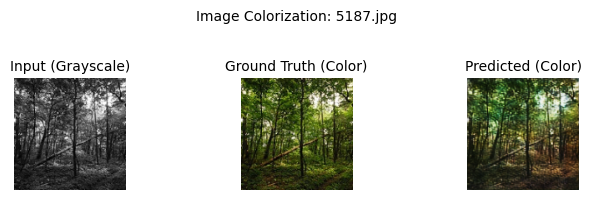

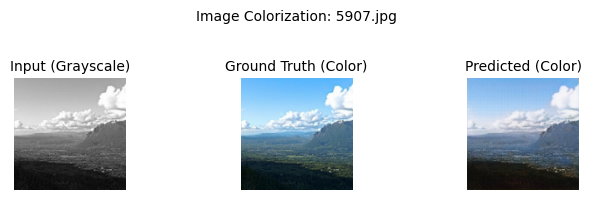

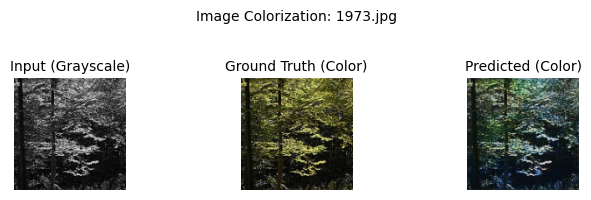

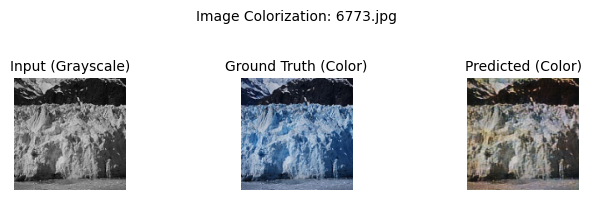

Epoch 9/25
Time taken: 39.56s
Training: Gen Loss: 10.7908, Gen GAN Loss: 1.1726, Gen L1 Loss: 0.0962, Disc Loss: 1.0198
Validation: Gen Loss: 12.4408, Gen GAN Loss: 0.7479, Gen L1 Loss: 0.1169, Disc Loss: 1.4049
Epoch 10/25
Time taken: 38.28s
Training: Gen Loss: 10.4895, Gen GAN Loss: 1.1934, Gen L1 Loss: 0.0930, Disc Loss: 1.0103
Validation: Gen Loss: 12.4732, Gen GAN Loss: 0.7095, Gen L1 Loss: 0.1176, Disc Loss: 1.3730
Epoch 11/25
Time taken: 37.63s
Training: Gen Loss: 10.2012, Gen GAN Loss: 1.1876, Gen L1 Loss: 0.0901, Disc Loss: 1.0163
Validation: Gen Loss: 12.3293, Gen GAN Loss: 0.7855, Gen L1 Loss: 0.1154, Disc Loss: 1.4866
Epoch 12/25
Time taken: 41.99s
Training: Gen Loss: 9.9175, Gen GAN Loss: 1.1677, Gen L1 Loss: 0.0875, Disc Loss: 1.0427
Validation: Gen Loss: 12.1636, Gen GAN Loss: 0.6629, Gen L1 Loss: 0.1150, Disc Loss: 1.3362


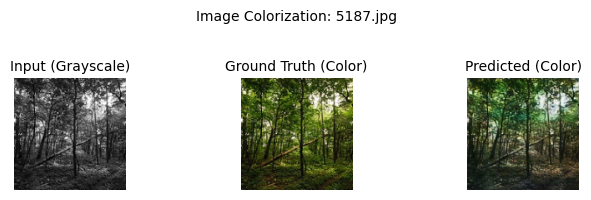

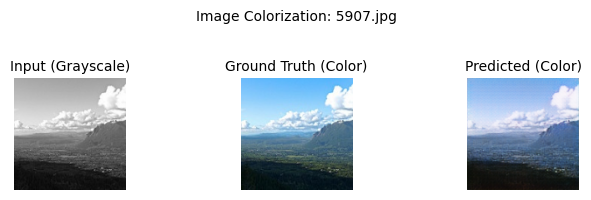

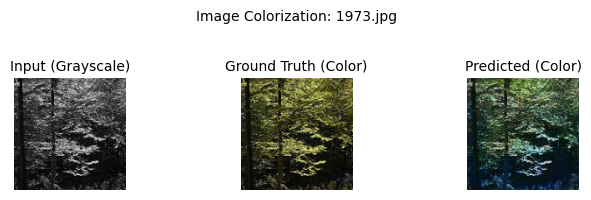

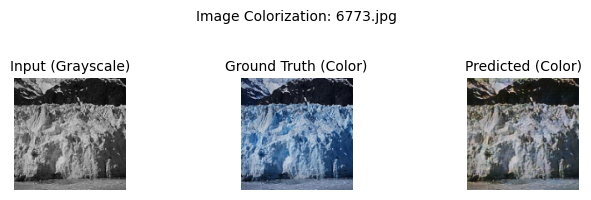

Epoch 13/25
Time taken: 40.71s
Training: Gen Loss: 9.6251, Gen GAN Loss: 1.1243, Gen L1 Loss: 0.0850, Disc Loss: 1.0697
Validation: Gen Loss: 12.1634, Gen GAN Loss: 0.6097, Gen L1 Loss: 0.1155, Disc Loss: 1.3738
Epoch 14/25
Time taken: 41.97s
Training: Gen Loss: 9.3548, Gen GAN Loss: 1.0799, Gen L1 Loss: 0.0827, Disc Loss: 1.1048
Validation: Gen Loss: 12.0006, Gen GAN Loss: 0.7433, Gen L1 Loss: 0.1126, Disc Loss: 1.3347
Epoch 15/25
Time taken: 42.75s
Training: Gen Loss: 9.1108, Gen GAN Loss: 1.0486, Gen L1 Loss: 0.0806, Disc Loss: 1.1207
Validation: Gen Loss: 11.9261, Gen GAN Loss: 0.6477, Gen L1 Loss: 0.1128, Disc Loss: 1.3544
Epoch 16/25
Time taken: 40.51s
Training: Gen Loss: 8.9360, Gen GAN Loss: 1.0436, Gen L1 Loss: 0.0789, Disc Loss: 1.1130
Validation: Gen Loss: 11.9596, Gen GAN Loss: 0.6677, Gen L1 Loss: 0.1129, Disc Loss: 1.3062


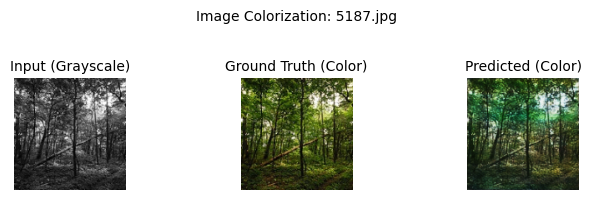

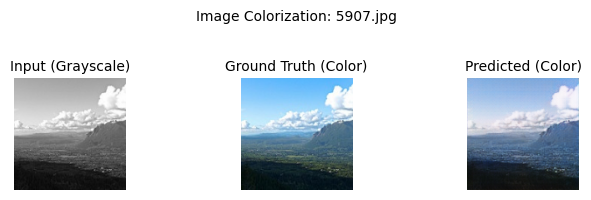

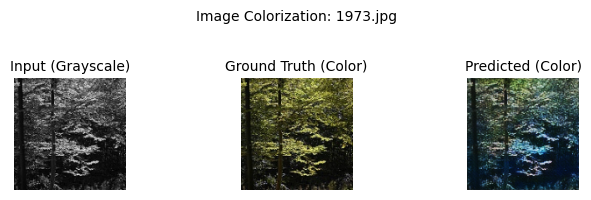

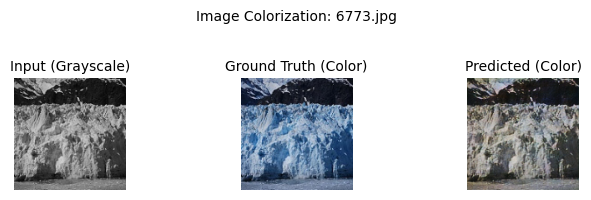

Epoch 17/25
Time taken: 40.38s
Training: Gen Loss: 8.7908, Gen GAN Loss: 1.0163, Gen L1 Loss: 0.0777, Disc Loss: 1.1498
Validation: Gen Loss: 11.9902, Gen GAN Loss: 0.7108, Gen L1 Loss: 0.1128, Disc Loss: 1.3531
Epoch 18/25
Time taken: 40.76s
Training: Gen Loss: 8.5528, Gen GAN Loss: 0.9722, Gen L1 Loss: 0.0758, Disc Loss: 1.1929
Validation: Gen Loss: 11.6491, Gen GAN Loss: 0.6046, Gen L1 Loss: 0.1104, Disc Loss: 1.3638
Epoch 19/25
Time taken: 42.05s
Training: Gen Loss: 8.3404, Gen GAN Loss: 0.9553, Gen L1 Loss: 0.0739, Disc Loss: 1.1985
Validation: Gen Loss: 11.3357, Gen GAN Loss: 0.6181, Gen L1 Loss: 0.1072, Disc Loss: 1.3608
Epoch 20/25
Time taken: 39.96s
Training: Gen Loss: 8.2106, Gen GAN Loss: 0.9526, Gen L1 Loss: 0.0726, Disc Loss: 1.1991
Validation: Gen Loss: 11.8028, Gen GAN Loss: 0.6405, Gen L1 Loss: 0.1116, Disc Loss: 1.3908


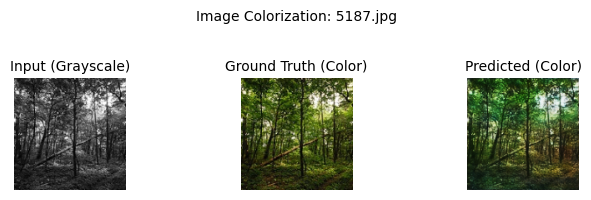

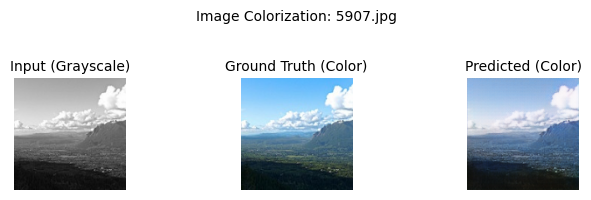

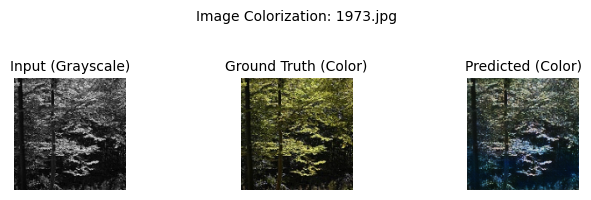

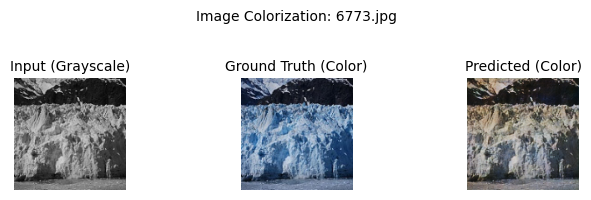

Epoch 21/25
Time taken: 38.30s
Training: Gen Loss: 8.0581, Gen GAN Loss: 0.9436, Gen L1 Loss: 0.0711, Disc Loss: 1.2021
Validation: Gen Loss: 11.4050, Gen GAN Loss: 0.6989, Gen L1 Loss: 0.1071, Disc Loss: 1.3875
Epoch 22/25
Time taken: 38.67s
Training: Gen Loss: 7.9179, Gen GAN Loss: 0.9405, Gen L1 Loss: 0.0698, Disc Loss: 1.2062
Validation: Gen Loss: 11.5198, Gen GAN Loss: 0.6790, Gen L1 Loss: 0.1084, Disc Loss: 1.3598
Epoch 23/25
Time taken: 39.51s
Training: Gen Loss: 7.8323, Gen GAN Loss: 0.9305, Gen L1 Loss: 0.0690, Disc Loss: 1.2154
Validation: Gen Loss: 11.4915, Gen GAN Loss: 0.6830, Gen L1 Loss: 0.1081, Disc Loss: 1.3462
Epoch 24/25
Time taken: 40.47s
Training: Gen Loss: 7.7343, Gen GAN Loss: 0.9258, Gen L1 Loss: 0.0681, Disc Loss: 1.2184
Validation: Gen Loss: 11.5098, Gen GAN Loss: 0.7199, Gen L1 Loss: 0.1079, Disc Loss: 1.3687


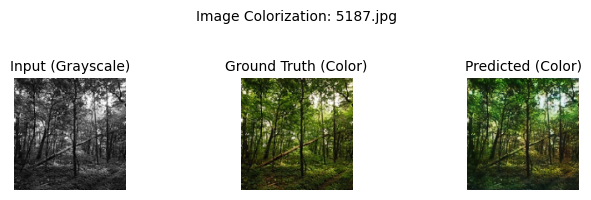

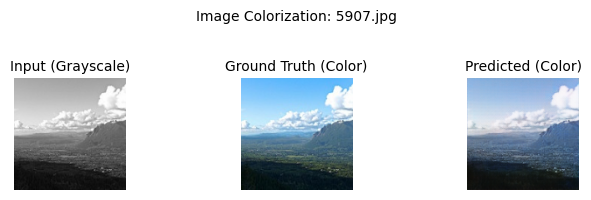

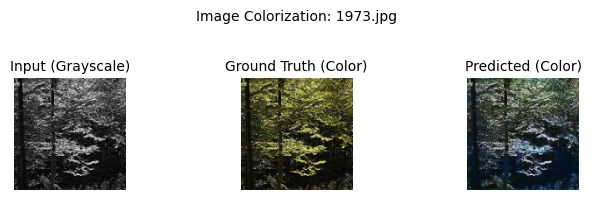

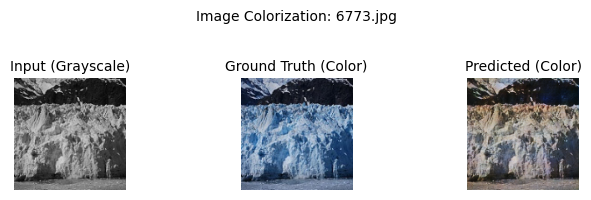

Epoch 25/25
Time taken: 37.94s
Training: Gen Loss: 7.5993, Gen GAN Loss: 0.9212, Gen L1 Loss: 0.0668, Disc Loss: 1.2185
Validation: Gen Loss: 11.4001, Gen GAN Loss: 0.6700, Gen L1 Loss: 0.1073, Disc Loss: 1.3679


In [26]:
generator, discriminator, losses = train_model(
        train_dataset, val_dataset, train_filenames_dataset, val_filenames_dataset, epochs=25)

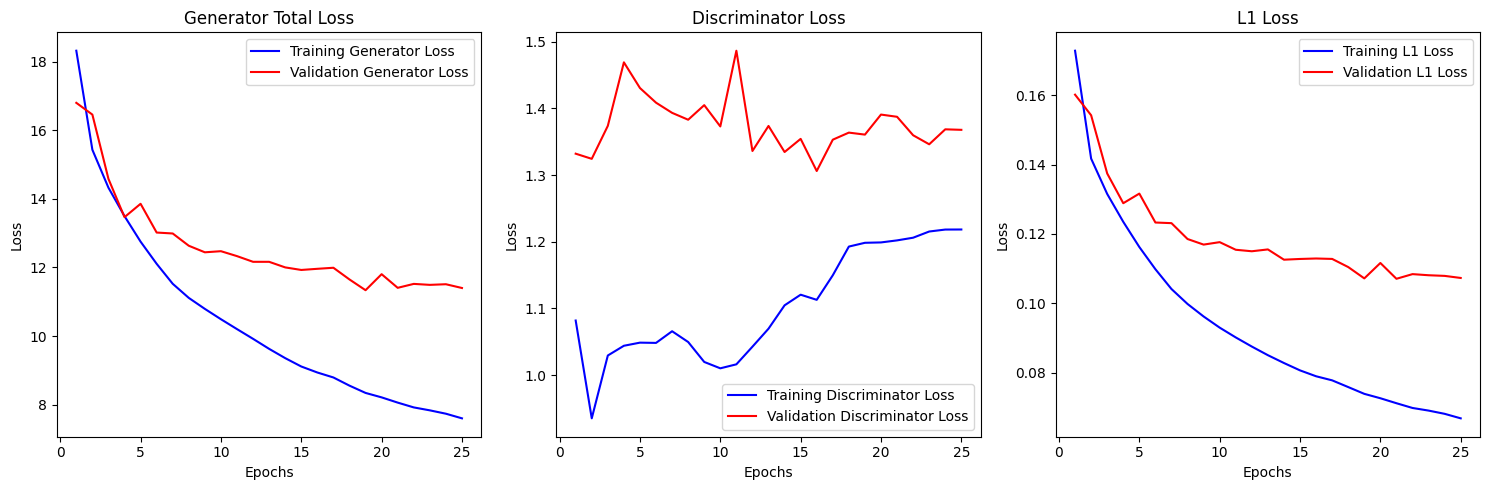

In [29]:
def plot_losses(train_gen_losses, train_disc_losses, train_l1_losses,
               val_gen_losses, val_disc_losses, val_l1_losses):
    epochs = range(1, len(train_gen_losses) + 1)
    
    # Plot generator losses
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_gen_losses, 'b-', label='Training Generator Loss')
    plt.plot(epochs, val_gen_losses, 'r-', label='Validation Generator Loss')
    plt.title('Generator Total Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_disc_losses, 'b-', label='Training Discriminator Loss')
    plt.plot(epochs, val_disc_losses, 'r-', label='Validation Discriminator Loss')
    plt.title('Discriminator Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    plt.plot(epochs, train_l1_losses, 'b-', label='Training L1 Loss')
    plt.plot(epochs, val_l1_losses, 'r-', label='Validation L1 Loss')
    plt.title('L1 Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('loss_plots.png')
    plt.show()


plot_losses(
    losses['train_gen_losses'],
    losses['train_disc_losses'],
    losses['train_l1_losses'],
    losses['val_gen_losses'],
    losses['val_disc_losses'],
    losses['val_l1_losses']
)

After tuning the hyperparameters, we were able to stablize the loss, while the discriminator nor generator loss did not experience a collapsing of the model

## Generating The Images using the validation set

In [41]:
def generate_validation_gallery(model, val_dataset, num_images=100, sets_per_file=4):
    """
    Generate gallery files, each containing a 2x2 grid of image sets
    
    Args:
        model: The trained generator model
        val_dataset: Validation dataset
        num_images: Total number of image sets to generate
        sets_per_file: Number of image sets per gallery file (4 for 2x2 grid)
    """
    os.makedirs('results/validation_gallery', exist_ok=True)
    
    # Calculate how many gallery files we need
    num_files = (num_images + sets_per_file - 1) // sets_per_file  # Ceiling division
    
    # Collect batches from validation dataset
    val_batches = []
    batch_count = 0
    for batch in val_dataset:
        val_batches.append(batch)
        batch_count += 1
        if batch_count * BATCH_SIZE >= num_images:
            break
    
    print(f"Generating {num_images} validation images across {num_files} gallery files...")
    
    # Process batches to create validation images
    img_count = 0
    gallery_count = 0
    
    for batch_idx, (input_batch, target_batch) in enumerate(val_batches):
        batch_size = input_batch.shape[0]
        
        for i in range(batch_size):
            if img_count >= num_images:
                break
                
            # Determine which gallery file and position this image set belongs to
            gallery_idx = img_count // sets_per_file
            position_in_gallery = img_count % sets_per_file
            
            # Create a new gallery file if needed
            if position_in_gallery == 0:
                gallery_fig, gallery_axes = plt.subplots(2, 2, figsize=(10, 5))
                gallery_count += 1
            
            # Calculate the position in the 2x2 grid
            row = position_in_gallery // 2
            col = position_in_gallery % 2
            
            # Get one image from batch
            input_image = input_batch[i:i+1]
            target_image = target_batch[i:i+1]
            
            # Generate colorized image
            predicted_image = model(input_image, training=False)
            
            # Create a figure for this image set
            set_fig, set_axes = plt.subplots(1, 3, figsize=(6, 2))
            
            # Populate the set figure with input, target, and predicted images
            images = [input_image[0], target_image[0], predicted_image[0]]
            titles = ['Input Grayscale', 'Ground Truth', 'Predicted Color']
            
            for j in range(3):
                set_axes[j].imshow(images[j] * 0.5 + 0.5)  # Denormalize
                set_axes[j].set_title(titles[j])
                set_axes[j].axis('off')
            
            plt.tight_layout()
            
            # Save the image set
            set_filename = f'results/validation_gallery/set_{img_count+1}.png'
            set_fig.savefig(set_filename)
            plt.close(set_fig)
            
            # Add this image set to the gallery
            # Load the saved image set
            img_set = plt.imread(set_filename)
            gallery_axes[row, col].imshow(img_set)
            gallery_axes[row, col].axis('off')
            
            # Save gallery if it's complete or we've reached the end
            if position_in_gallery == sets_per_file - 1 or img_count == num_images - 1:
                gallery_filename = f'results/validation_gallery/gallery_{gallery_idx+1}.png'
                gallery_fig.tight_layout()
                gallery_fig.savefig(gallery_filename)
                plt.close(gallery_fig)
            
            img_count += 1
            
            if img_count >= num_images:
                break
    
    print(f"Generated {img_count} validation image sets across {gallery_count} gallery files")
    print(f"Gallery files saved in 'results/validation_gallery/'")


print("Generating validation image gallery...")
generate_validation_gallery(generator, val_dataset, num_images=100, sets_per_file=4)

Generating validation image gallery...
Generating 100 validation images across 25 gallery files...
Generated 100 validation image sets across 25 gallery files
Gallery files saved in 'results/validation_gallery/'


## Exploring Some Generated Files

![image](./results/validation_gallery/gallery_1.png)
![image](./results/validation_gallery/gallery_2.png)
![image](./results/validation_gallery/gallery_3.png)
![image](./results/validation_gallery/gallery_4.png)
![image](./results/validation_gallery/gallery_5.png)

The model performed very well on nature photos, but did not do well on urban environment that includes colors from buildings and clothing.  However, even though the accuracy of the actual color from buildings/people were not so great, it still would 


# Conclusion
Colorization is a unique challenge where the optics of the human takes priorities over reducing a numerical loss.

Several lessons were learned.
- Nvidia CUDA library is sensitive to version of Kera, Python
- GPU based training is exponentially better.
- In GPU based environment, the memory becomes the main constraint, vs CPU based environment where the compute resource was the main constraint.
- CUDA performs much better when the data sizes are in the powers of 2.  For example 128x128 images performed much better in terms of memory efficiency than 100x100 images.
- Pix2Pix yields a very good colorization from very early and only gests marginally better through more epochs


## Further Studies
We could potentially extend the model by introducing a human in the loop, where human could provide additional context where only grayscale images exist.  They could provide context on whether more color saturation is preferred or not.  Or more variations of colors or not.

Also, although we have not learned nor am I deeply aware, it seems like newer architecture called diffusion models seems to be much more effective in generating images.  This may present additional options.
